In [11]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import os
import pyodbc
import configparser

# Authenticate using your Google API credentials
scope = [
    'https://spreadsheets.google.com/feeds',
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

credentials = ServiceAccountCredentials.from_json_keyfile_name(
    'C:\\Users\\Moshood\\OneDrive\\dev\\python_data_profiling_scripts\\BODQR\\service_account.json', scopes=scope
)

file = gspread.authorize(credentials)

# Open the Google Sheet
workbook = file.open("bo_data")

# Select the worksheet you want to access   pip 
worksheet = workbook.worksheet("Raw")

# Convert the worksheet data to a data frame
data = pd.DataFrame(worksheet.get_all_values(), columns=worksheet.row_values(1))

data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Adding New columns
data['asset_tag_dup_or_not'] = data.duplicated(subset='Asset Tag', keep=False).map({True: 'Duplicate', False: ''})
data['customerid'] = [data.loc[i, 'Customer Account Number'] if data.loc[i, 'Customer Account Number'] != "" else data.loc[i, 'Customer Meter SLRN (ECG)'] if data.loc[i, 'Customer Meter SLRN (ECG)'] != "" else data.loc[i, 'Customer Account Number'] if data.loc[i, 'Customer Account Number'] != "" and data.loc[i, 'Customer Meter SLRN (ECG)'] != "" else data.loc[i, 'Customer Meter SLRN (ECG)'] for i in range(len(data))]
data['customerid_dup_or_not'] = data.duplicated(subset='customerid', keep=False).map({True: 'Duplicate', False: ''})
data['asset_tag_dup_flag'] = 0
data.loc[(data['Asset Tag'].notnull()) & (data['asset_tag_dup_or_not'] != 'Duplicate'), 'asset_tag_dup_flag'] = 1
data['customerid_dup_flag'] = 0
data.loc[(data['customerid'].notnull()) & (data['customerid_dup_or_not'] != 'Duplicate'), 'customerid_dup_flag'] = 1
def asset_type(asset_tag_dup_flag, asset_type):
    if asset_tag_dup_flag == 1 and asset_type == "Distribution Transformer (DT)":
        return "DT"
    elif (asset_tag_dup_flag == 1 and asset_type == "Building") or (asset_tag_dup_flag == 1 and asset_type == "Building & Customer / Meter"):
        return "Building"
    else:
        return "Duplicate Data"
data['asset_type'] = data.apply(lambda x: asset_type(x['asset_tag_dup_flag'], x['Asset Type']), axis=1)
data['month'] = data['Timestamp'].dt.strftime('%B')
data['year'] = data['Timestamp'].dt.strftime('%Y')
data["week_month"] = data["Timestamp"].dt.strftime("Week %U - %B")
data['day_of_week'] = data['Timestamp'].dt.day_name()
data['month_year'] = data['Timestamp'].dt.strftime('%B - %Y')
data['data_audit_approve'] = np.where((data['Data Audit Review'] == 'Approve') & (data['customerid_dup_or_not'] != 'Duplicate'), 1, 0)
data['data_audit_reject'] = np.where((data['Data Audit Review'] == 'Reject') & (data['customerid_dup_or_not'] != 'Duplicate'), 1, 0)


# Connect to the database
config = configparser.ConfigParser()
config.read('config.ini')

ecg_server_name = config['ecg_database']['ecg_server_name']
ecg_database_name = config['ecg_database']['ecg_database_name']
ecg_user_name = config['ecg_database']['ecg_user_name']
ecg_password = config['ecg_database']['ecg_password']

aedc_server_name = config['aedc_database']['aedc_server_name']
aedc_database_name = config['aedc_database']['aedc_database_name']
aedc_user_name = config['aedc_database']['aedc_user_name']
aedc_password = config['aedc_database']['aedc_password']

ecg_connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={ecg_server_name};DATABASE={ecg_database_name};UID={ecg_user_name};PWD={ecg_password}"
aedc_connection_string = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={aedc_server_name};DATABASE={aedc_database_name};UID={aedc_user_name};PWD={aedc_password}"

ecg_cnxn = pyodbc.connect(ecg_connection_string)
aedc_cnxn = pyodbc.connect(aedc_connection_string)
ecg_all_assets = pd.read_sql("""select * from vw_all_assets""", ecg_cnxn)
aedc_all_assets = pd.read_sql("""select * from vw_all_assets""", aedc_cnxn)



C:\Users\Moshood\AppData\Local\Temp\ipykernel_37616\692180249.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ecg_all_assets = pd.read_sql("""select * from vw_all_assets""", ecg_cnxn)
C:\Users\Moshood\AppData\Local\Temp\ipykernel_37616\692180249.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  aedc_all_assets = pd.read_sql("""select * from vw_all_assets""", aedc_cnxn)


In [12]:
jan = data[data['month_year'] == 'February - 2023']
jan

,Timestamp,Email Address,Site,Date Picked,Asset Type,Asset Tag,Username,SLRN Value Matches Picture,Invalid Data Item(s),Picture(s) to retake,...,asset_tag_dup_flag,customerid_dup_flag,asset_type,month,year,week_month,day_of_week,month_year,data_audit_approve,data_audit_reject
30562,2023-02-07 10:49:00,gokea@bpsafrica.com,ECG,19/10/2022,Building & Customer / Meter,ECGBD0035035,JoshuaA,Yes,,"Mounted tag pictures, Card Picture",...,1,1,Building,February,2023,Week 06 - February,Tuesday,February - 2023,1,0
48791,2023-02-01 06:47:00,jelilia@bpsafrica.com,ECG,18/10/2022,Building & Customer / Meter,ECGBD0027752,JusticeT,Not Clear,,Mounted tag pictures,...,0,1,Duplicate Data,February,2023,Week 05 - February,Wednesday,February - 2023,0,1
48792,2023-02-01 06:52:00,jelilia@bpsafrica.com,ECG,18/10/2022,Building & Customer / Meter,ECGBD0027748,JusticeT,Not Clear,,All Images should be retaken,...,1,1,Building,February,2023,Week 05 - February,Wednesday,February - 2023,0,1
48793,2023-02-01 06:56:00,jelilia@bpsafrica.com,ECG,18/10/2022,Building & Customer / Meter,ECGBD0027746,JusticeT,Yes,,All Images were captured correctly,...,1,1,Building,February,2023,Week 05 - February,Wednesday,February - 2023,1,0
48794,2023-02-01 06:59:00,jelilia@bpsafrica.com,ECG,18/10/2022,Building & Customer / Meter,ECGBD0027744,JusticeT,Not Clear,,Mounted tag pictures,...,0,0,Duplicate Data,February,2023,Week 05 - February,Wednesday,February - 2023,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52885,2023-02-10 08:33:00,okanlawono@bpsafrica.com,AEDC,3/2/2023,Building & Customer / Meter,AEDCBD0009097,OnwuzurikeC,Yes,,All Images were captured correctly,...,0,1,Duplicate Data,February,2023,Week 06 - February,Friday,February - 2023,1,0
52886,2023-02-10 08:36:00,emmanuelo@bpsafrica.com,ECG,15/10/2022,Building & Customer / Meter,ECGBD0029732,EdwardK,Yes,,"Bill pictures, Mounted tag pictures, Card Picture",...,0,0,Duplicate Data,February,2023,Week 06 - February,Friday,February - 2023,0,0
52887,2023-02-10 08:42:00,okanlawono@bpsafrica.com,AEDC,3/2/2023,Building & Customer / Meter,AEDCBD0009863,DanladiB,Yes,,All Images were captured correctly,...,0,1,Duplicate Data,February,2023,Week 06 - February,Friday,February - 2023,1,0
52888,2023-02-10 08:47:00,okanlawono@bpsafrica.com,AEDC,3/2/2023,Building & Customer / Meter,AEDCBD0009863,DanladiB,Yes,,All Images were captured correctly,...,0,1,Duplicate Data,February,2023,Week 06 - February,Friday,February - 2023,1,0


In [33]:
# calculate the sum of asset_tag_dup_flag
ecg_audit_data = data[data['Site'] == 'ECG']
aedc_audit_data = data[data['Site'] == 'AEDC']

ecg_overall_assets_reviewed = ecg_audit_data['asset_tag_dup_flag'].sum()
print(f"Overall Assets Reviewed - ECG: {ecg_overall_assets_reviewed:,}")

# calculate the sum of customerid_dup_flag
ecg_overall_customers_reviewed = ecg_audit_data['customerid_dup_flag'].sum()
print(f"Overall Customers Reviewed - ECG: {ecg_overall_customers_reviewed:,}")

# calculate the sum of data_audit_approve
ecg_total_approved = ecg_audit_data['data_audit_approve'].sum()
print(f"Total Approved - ECG: {ecg_total_approved:,}")

# calculate the sum of data_audit_reject
ecg_total_rejected = ecg_audit_data['data_audit_reject'].sum()
print(f"Total Rejected - ECG: {ecg_total_rejected:,}")

ecg_total_customers = ecg_all_assets['ac_no'].nunique()
ecg_total_assets = ecg_all_assets['slrn'].nunique()

print(f'Of the {ecg_total_customers:,} customers enumerated, {ecg_overall_customers_reviewed:,} have been audited by the back office team')
print(f'Of the {ecg_total_assets:,} assets enumerated, {ecg_overall_assets_reviewed:,} have been audited by the back office team')

Overall Assets Reviewed - ECG: 15,879
Overall Customers Reviewed - ECG: 37,456
Total Approved - ECG: 25,118
Total Rejected - ECG: 9,273
Of the 72,477 customers enumerated, 37,456 have been audited by the back office team
Of the 59,359 assets enumerated, 15,879 have been audited by the back office team


In [34]:
# calculate the sum of asset_tag_dup_flag
aedc_audit_data = data[data['Site'] == 'AEDC']

aedc_overall_assets_reviewed = aedc_audit_data['asset_tag_dup_flag'].sum()
print(f"Overall Assets Reviewed - AEDC: {aedc_overall_assets_reviewed:,}")

# calculate the sum of customerid_dup_flag
aedc_overall_customers_reviewed = aedc_audit_data['customerid_dup_flag'].sum()
print(f"Overall Customers Reviewed - AEDC: {aedc_overall_customers_reviewed:,}")

# calculate the sum of data_audit_approve
aedc_total_approved = aedc_audit_data['data_audit_approve'].sum()
print(f"Total Approved - AEDC: {aedc_total_approved:,}")

# calculate the sum of data_audit_reject
aedc_total_rejected = aedc_audit_data['data_audit_reject'].sum()
print(f"Total Rejected - AEDC: {aedc_total_rejected:,}")

aedc_total_customers = aedc_all_assets['ac_no'].nunique()
aedc_total_assets = aedc_all_assets['slrn'].nunique()

print(f'Of the {aedc_total_customers:,} customers enumerated, {aedc_overall_customers_reviewed:,} have been audited by the back office team')
print(f'Of the {aedc_total_assets:,} assets enumerated, {aedc_overall_assets_reviewed:,} have been audited by the back office team')


Overall Assets Reviewed - AEDC: 3,331
Overall Customers Reviewed - AEDC: 6,061
Total Approved - AEDC: 4,796
Total Rejected - AEDC: 156
Of the 19,431 customers enumerated, 6,061 have been audited by the back office team
Of the 12,228 assets enumerated, 3,331 have been audited by the back office team


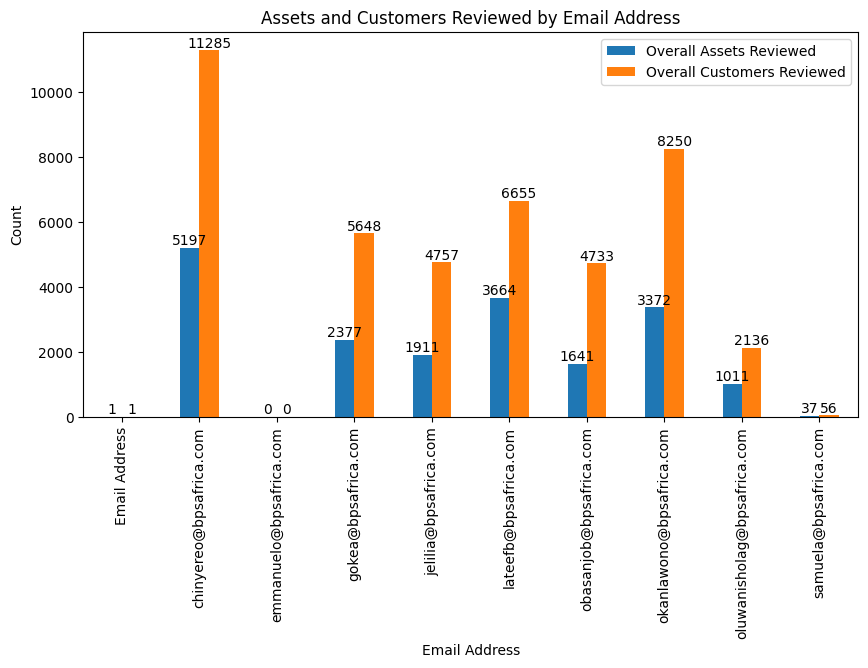

<Figure size 640x480 with 0 Axes>

In [4]:
import matplotlib.pyplot as plt

grouped = data.groupby('Email Address').agg({'asset_tag_dup_flag': 'sum', 'customerid_dup_flag': 'sum'})

fig, ax = plt.subplots()
grouped.plot(kind='bar', ax=ax, figsize=(10, 5))

plt.title("Assets and Customers Reviewed by Email Address")
plt.xlabel("Email Address")
plt.ylabel("Count")

# Adding count values on top of the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

# Rename legend
plt.legend(["Overall Assets Reviewed", "Overall Customers Reviewed"])

plt.show()

# Save the chart as an image file
plt.savefig("assets_customers_reviewed_by_email_address.png")
plt.savefig("C:/Users/Moshood/Downloads/assets_customers_reviewed_by_email_address.png")

In [39]:
grouped = data.groupby(['Site', ]).agg({'asset_tag_dup_flag': 'sum', 'customerid_dup_flag': 'sum'})
print(grouped)

           asset_tag_dup_flag  customerid_dup_flag
Site                                              
AEDC                     3331                 6061
AEDC, ECG                   0                    3
ECG                     15879                37456
Site                        1                    1


In [134]:
import pandas as pd
import numpy as np
import datetime

# Define the start and end dates for the current and previous week
# Define the start and end dates for the current and previous week

today = datetime.datetime.now()
this_week_end_date = today
this_week_start_date = today - datetime.timedelta(days=5)
prev_week_end_date = this_week_start_date
prev_week_start_date = prev_week_end_date - datetime.timedelta(days=4)

start_date = pd.to_datetime('2022-09-05')
current_date = pd.to_datetime(datetime.datetime.now().date())

# Filter data for the overall week
week = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] < current_date)]

# Filter data for the current week
this_week = data[(data['Timestamp'] >= this_week_start_date) & (data['Timestamp'] < this_week_end_date)]

# Filter data for the previous week
prev_week = data[(data['Timestamp'] >= prev_week_start_date) & (data['Timestamp'] < prev_week_end_date)]

# Calculate the sum of the asset_tag_dup_flag and customerid_dup_flag columns for this week and previous week
asset_count_this_week = this_week['asset_tag_dup_flag'].sum()
customer_count_this_week = this_week['customerid_dup_flag'].sum()
asset_count_prev_week = prev_week['asset_tag_dup_flag'].sum()
customer_count_prev_week = prev_week['customerid_dup_flag'].sum()

# Calculate the weekly rate of assets and customers audited
asset_rate_this_week = (asset_count_this_week / len(this_week)) * 100 
customer_rate_this_week = (customer_count_this_week / len(this_week)) * 100
asset_rate_prev_week = (asset_count_prev_week / len(prev_week)) * 100
customer_rate_prev_week = (customer_count_prev_week / len(prev_week)) * 100


# Calculate the sum of the asset_tag_dup_flag and customerid_dup_flag columns
asset_count = week['asset_tag_dup_flag'].sum()
customer_count = week['customerid_dup_flag'].sum()

# Calculate the weekly rate of assets and customers audited
asset_rate = (asset_count / len(week)) * 100
customer_rate = (customer_count / len(week)) * 100

# Print the results
print("Asset count this week:", asset_count_this_week)
print("Asset rate this week: {:.2f}%".format(asset_rate_this_week))
print("Customer count this week:", customer_count_this_week)
print("Customer rate this week: {:.2f}%".format(customer_rate_this_week))
print("Asset count prev week:", asset_count_prev_week)
print("Asset rate prev week: {:.2f}%".format(asset_rate_prev_week))
print("Customer count prev week:", customer_count_prev_week)
print("Customer rate prev week: {:.2f}%".format(customer_rate_prev_week))

# Print the results
print('Weekly Asset rate: {:.2f}%'.format(asset_rate))
print('Weekly Customer rate: {:.2f}%'.format(customer_rate))


Asset count this week: 851
Asset rate this week: 32.08%
Customer count this week: 2581
Customer rate this week: 97.29%
Asset count prev week: 357
Asset rate prev week: 34.76%
Customer count prev week: 965
Customer rate prev week: 93.96%
Weekly Asset rate: 36.31%
Weekly Customer rate: 82.28%


In [133]:
import pandas as pd
import numpy as np

# Define the start and end dates for the current and previous week
# this_week_start_date = pd.to_datetime('2022-02-05')
# this_week_end_date = pd.to_datetime('2022-02-11')
# prev_week_start_date = pd.to_datetime('2022-02-01')
# prev_week_end_date = pd.to_datetime('2022-02-04')

this_week_end_date = today
this_week_start_date = today - datetime.timedelta(days=5)
prev_week_end_date = this_week_start_date
prev_week_start_date = prev_week_end_date - datetime.timedelta(days=4)

# Filter data for the current week
this_week = data[(data['Timestamp'] >= this_week_start_date) & (data['Timestamp'] < this_week_end_date)]

# Filter data for the previous week
prev_week = data[(data['Timestamp'] >= prev_week_start_date) & (data['Timestamp'] < prev_week_end_date)]

# Calculate the sum of the asset_tag_dup_flag and customerid_dup_flag columns for this week and previous week
asset_count_this_week = this_week['asset_tag_dup_flag'].sum()
customer_count_this_week = this_week['customerid_dup_flag'].sum()
asset_count_prev_week = prev_week['asset_tag_dup_flag'].sum()
customer_count_prev_week = prev_week['customerid_dup_flag'].sum()

# Calculate the weekly rate of assets and customers audited
asset_rate_this_week = (asset_count_this_week / len(this_week)) * 100
customer_rate_this_week = (customer_count_this_week / len(this_week)) * 100
asset_rate_prev_week = (asset_count_prev_week / len(prev_week)) * 100
customer_rate_prev_week = (customer_count_prev_week / len(prev_week)) * 100

# Comparison metric #1: Weekly increase/decrease in the number of assets audited
asset_diff = asset_count_this_week - asset_count_prev_week
if asset_diff > 0:
    print("The number of assets audited increased by", asset_diff, "from last week.")
else:
    print("The number of assets audited decreased by", abs(asset_diff), "from last week.")

# Comparison metric #2: Weekly increase/decrease in the number of customers audited
customer_diff = customer_count_this_week - customer_count_prev_week
if customer_diff > 0:
    print("The number of customers audited increased by", customer_diff, "from last week.")
else:
    print("The number of customers audited decreased by", abs(customer_diff), "from last week.")

# Comparison metric #3: Weekly increase/decrease in the rate of assets audited
asset_rate_diff = asset_rate_this_week - asset_rate_prev_week
if asset_rate_diff > 0:
    print("The rate of assets audited increased by", asset_rate_diff, "% from last week.")
else:
    print("The rate of assets audited decreased by", abs(asset_rate_diff), "% from last week.")

# Comparison metric #4


The number of assets audited increased by 484 from last week.
The number of customers audited increased by 1590 from last week.
The rate of assets audited decreased by 2.448035362795949 % from last week.


In [131]:
this_week_end_date = today
this_week_start_date = today - datetime.timedelta(days=5)
prev_week_end_date = this_week_start_date
prev_week_start_date = prev_week_end_date - datetime.timedelta(days=4)

In [132]:
print(this_week_end_date)
print(this_week_start_date)
print(prev_week_end_date )
print(prev_week_start_date)

2023-02-10 13:38:53.032286
2023-02-05 13:38:53.032286
2023-02-05 13:38:53.032286
2023-02-01 13:38:53.032286


In [80]:
k = data[(data['week_month'] == 'Week 06 - February') & (data['year'] == '2023')]
if k.empty:
    print("Dataframe is empty")
else:
    print("Dataframe is not empty")
    k.sample()



Dataframe is not empty


In [81]:
c = k['asset_tag_dup_flag'].sum()
c

864

In [137]:
# calculate the count of customers audited this week and previous week
today = pd.to_datetime('today')
this_week_start = today - datetime.timedelta(days=5) #today - pd.Timedelta(days=today.weekday())
prev_week_start = this_week_start - datetime.timedelta(days=4) #this_week_start - pd.Timedelta(days=7)


this_week_customers = len(data[(data['Timestamp'] >= this_week_start) & (data['customerid_dup_flag'] == 1)])
prev_week_customers = len(data[(data['Timestamp'] >= prev_week_start) & (data['Timestamp'] < this_week_start) & (data['customerid_dup_flag'] == 1)])

# calculate the count of assets audited this week and previous week
this_week_assets = len(data[(data['Timestamp'] >= this_week_start) & (data['asset_tag_dup_flag'] == 1)])
prev_week_assets = len(data[(data['Timestamp'] >= prev_week_start) & (data['Timestamp'] < this_week_start) & (data['asset_tag_dup_flag'] == 1)])

# calculate the weekly rate of assets audited
total_assets = len(data[data['asset_tag_dup_flag'] == 1])
weekly_assets_rate = 100 * (this_week_assets / total_assets)

# calculate the weekly rate of customers audited
total_customers = len(data[data['customerid_dup_flag'] == 1])
weekly_customers_rate = 100 * (this_week_customers / total_customers)

# print the result
print(f"This week, {this_week_customers} customers were audited, and {prev_week_customers} customers were audited the previous week.")
print(f"This week, {weekly_customers_rate:.2f}% of customers were audited, and {prev_week_assets} assets were audited the previous week.")
print(f"This week, {this_week_assets} assets were audited, and {prev_week_assets} assets were audited the previous week.")
print(f"This week, {weekly_assets_rate:.2f}% of assets were audited.")


This week, 2581 customers were audited, and 963 customers were audited the previous week.
This week, 5.93% of customers were audited, and 357 assets were audited the previous week.
This week, 851 assets were audited, and 357 assets were audited the previous week.
This week, 4.43% of assets were audited.


## Finding Missing Dates

In [176]:
import pandas as pd
from datetime import datetime, timedelta, date
import os

bo_data = "C:\\Users\\Moshood\\Downloads\\bo_data_checking gaps_in_date_column.xlsx"
bo_data = pd.read_excel(bo_data)

# Filter the data for a particular site
site = "ECG"
filtered_data = bo_data[bo_data["Site"] == site]

# Adding column 'Site' to the dictionary of lists
d = filtered_data[["Timestamp", "Site"]].copy()
d["Timestamp"] = d["Timestamp"].dt.strftime("%Y-%m-%d")

# Creating dataframe from the above dictionary of lists
dataFrame = pd.DataFrame(d)

# Timestamp set as index
dataFrame = dataFrame.set_index('Timestamp')

# Using to_datetime() to convert string to DateTime object
dataFrame.index = pd.to_datetime(dataFrame.index)

# Missing dates displayed as output
k = pd.date_range(start=dataFrame.index.min(), end=dataFrame.index.max()).difference(dataFrame.index)

# Convert the DatetimeIndex object to a DataFrame
k = pd.DataFrame(k, columns=['Timestamp'])

# ---------------------------------------------------------------------------------------------------------
# Exporting the dataframe to a csv file in a specific directory
directory = r"C:/Users/Moshood/OneDrive/dev/python_data_profiling_scripts/BODQR/exports/docs/"
today = date.today()
now = datetime.now()
if not os.path.exists(directory):
    os.makedirs(directory)

# name of the file
result = k
filename = "export"
filepath = directory + filename

# Save the result to a CSV file
result.to_csv(directory + site + f'_missing_dates_{filename}_{now.strftime("%Y-%m-%d %H-%M-%S")}.csv', index=False)

# ---------------------------------------------------------------------------------------------------------

"""
    Ensure that the source data date column is well formated, this was was tested using 
    an Excel document (Microsoft).
"""